## Решающие деревья

Вернемся к задаче классификации, и вспомним задачу об ирисах.

In [6]:
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np
#from sklearn import 
iris = sklearn.datasets.load_iris()
data = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y = iris['target']

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

In [8]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Для простоты давайте будем учиться отличать второй класс от нулевого и первого, то есть таргет будет устроен так:

In [42]:
y =  np.array(y < 1, dtype=int)

In [10]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Можно подойти к решению этой задачи так: у каждого примера есть четрые признака, $x_1, \dots, x_4$. Давайте найдем вопрос вида "Верно ли, что $x_i  < a$?", который дает больше всего информации о типе цветка.

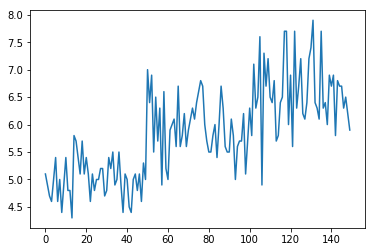

In [11]:
plt.plot(data['sepal length (cm)'])

Нам нужно научиться выбирать самый хороший вопрос.

Для начала давайте рассмотрим какой-нибудь пример, скажем sepal length > 6 и посмотрим, сколько примеров каждого класса удовлетворяет этому условию:

In [12]:
condition = data['sepal length (cm)'] > 6
print('Sepal length > 6 and target 1:', sum(y[condition]))
print('Sepal length > 6 and target 0:', sum(1 - y[condition]))
print()
condition = data['sepal length (cm)'] < 6
print('Sepal length < 6 and target 1:', sum(y[condition]))
print('Sepal length < 6 and target 0:', sum(1 - y[condition]))


Sepal length > 6 and target 1: 20
Sepal length > 6 and target 0: 41

Sepal length < 6 and target 1: 76
Sepal length < 6 and target 0: 7


Нам нужно понять, хорошо это или плохо. Если мы должны сделать наше предсказание глядя только на эти результаты мы припишем документам, для которых sepal_length > 6 вероятность $p_1$ оказаться в классе 1, а для тех у которых sepal_length < 6 вероятность $p_2$.

Вспомним метрику LogLoss, которую мы оптимизировали:
$$
  -\sum_{x \in 1} \ln p_x - \sum_{x \in 0} \ln (1-p_x)
$$

Нужно выбрать p_1 и p_2 так, чтобы минимизировать эту функцию. Ясно, что выбирать их можно независимо. Посмотрим, что происходит в случае sepal length > 6. Наше выражение для функции потерь превращается в
$$
  - A \ln p_1 - B \ln (1-p_1),
$$
в нашем случае A = 20, B = 41.


Если найти значение p, при котором достигается максимум этой функции, мы получим $p = \frac{A}{A+B}$.

Заметим, что этот число -- в точности "наблюдаемая" для тех цветов, у которых sepal length > 6 вероятность оказаться в классе 1.


Естественно считать, что лучшим вопросом будет тот, для которого суммарный LogLoss будет минимальным. Давайте напишем функцию, которая оценивает качество каждого вопроса

In [13]:
def rate_question(feature, threshold):
    condition = data[feature] < threshold
    lower = y[condition]
    higher = y[condition ^ True]
    p1 = sum(lower) / len(lower) if len(lower) else 0
    p2 = sum(higher) / len(higher) if len(higher) else 0
    loss = 0
    if 0 < p1 < 1.0:
        loss -= sum(lower) * np.log(p1) + sum(1-lower) * np.log(1-p1)
    if 0 < p2 < 1.0:
        loss -= sum(higher) * np.log(p2) + sum(1-higher) * np.log(1-p2)
        
    return loss

Теперь мы можем проверить качество разбиения для любого вопроса:

In [15]:
rate_question('sepal length (cm)', 6)

67.71617413799011

Можем, например перебрать все возможные вопросы (точнее не все, а, например, по 100 значений для каждого признака) и выбрать лучший.

__Задание__: сделайте это. Какую точность дает такой классификатор?

Описанную конструкцию удобно визуализировать как бинарное дерево, в корне которого стоит вопрос, а листья соответствуют ответам нашего предсказания:

Для визуализации понадобится пакет graphviz. Его можно установить командой

conda install python-graphviz

возможно для этого нужно будет запустить anaconda command prompt


In [16]:
import graphviz

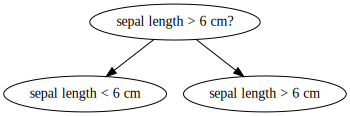

In [17]:
dot = graphviz.Digraph(comment='Decision tree')
dot.node('A', 'sepal length > 6 cm?')
dot.node('B', 'sepal length < 6 cm')
dot.node('C', 'sepal length > 6 cm')
dot.edge('A', 'B')
dot.edge('A', 'C')
dot

Дальше мы можем в каждом из листьев подобрать еще какой нибудь вопрос. 

__Задание__: Сделайте это.

In [ ]:
Этот алгоритм реализован в sklearn в классе

In [20]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(data, y);

Полученное дерево можно удобно визуализировать:


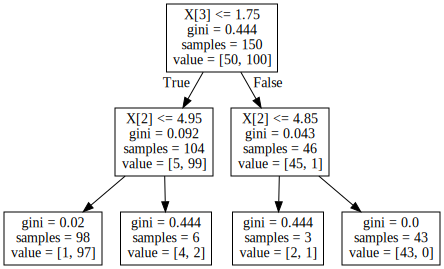

In [23]:
tree_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(tree_data)

Можем построить дерево большей глубины

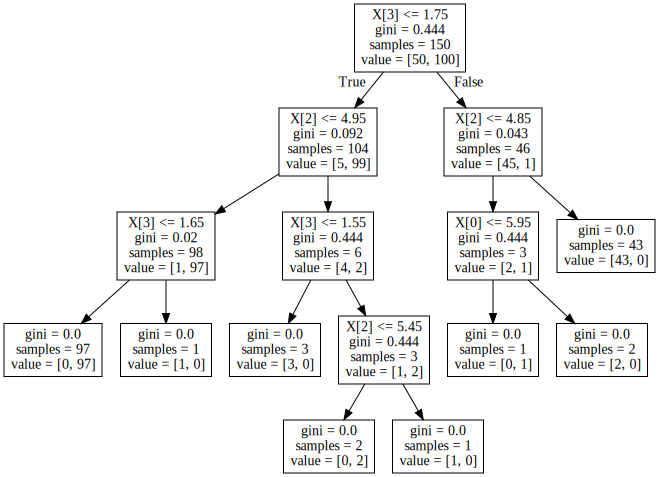

In [24]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(data, y);
tree_data = tree.export_graphviz(clf, out_file=None)
graphviz.Source(tree_data)

Полученное дерево уже научилось различать все примеры

Вот тут есть красивая демонстрация того, как работает классификатор в виде решающего дерева
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py
Обратите внимание, что области, отнесенные к каждому классу составлены из прямоугольников. Это всегда получается так при использовании решающих деревьев.

Давайте теперь вспомним, что правильно обучаться и проверяться на разных множествах. Пример с ирисами не очень интересный: их на самом деле довольно легко различать, поэтому давайте посмотрим на датасет про пульсары:

In [44]:
from sklearn.model_selection import train_test_split

data1 = pd.read_csv('pulsar_stars.csv')

X = data1.drop(columns=['target_class'])
Y = data1['target_class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
Обучим классификатор и посмотрим на его accuracy:

In [192]:
    clf = tree.DecisionTreeClassifier(max_depth=3)
    clf.fit(X_train, Y_train);
    score = clf.score(X_test, Y_test) #, sample_weight=1 + 10 * Y_test )
    print(score)

0.9783307939732521


__Задание__: Посмотрите, как качество на тесте зависит от глубины дерева. При какой глубине качество наилучшее? 

Как вы увидели в предыдущей задаче, при большой глубине дерева классификатор может сильно переобучаться. Есть полезный трюк, который позволяет частично решить 
эту проблему: можно обучить несколько разных деревьев и усреднить их предсказания. Каждое из них будет переобучаться по разному, поэтому если усреднить их предсказания ошибка скорее всего будет меньше. Для того, чтобы деревья действительно получались разными, будем обучать их на немного разных множествах данных. Такой подход называется Random Forest (случайный лес)

__Задание__: Дополните реализацию этого алгоритма

In [ ]:
    ntrees = 11
    res = np.zeros(Y_test.shape) # Здесь мы будем сохранять результаты каждого отдельного дерева
    for i in range(ntrees):
            X_train1, _, Y_train1, _ = train_test_split(X_train, Y_train, test_size=0.2) # Выберем случайное подмножество трейна
            ??? 
            ... # тут нужно обучить решающее дерево на X_train1 и применить к X_test 
            ???
    pred = ??? # и из предсказаний каждого классификатора сделать одно "усредненное"
    print(np.mean(pred==Y_test))

Естественно, в sklearn есть класс в котором все это реализовано за вас:

In [201]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier( n_estimators=11, max_depth=10)

__Задание__: Посмотрите, как качество на тесте зависит от глубины дерева и от количества деревьев в "лесу". 

Как можно догадаться из названия модуля, методы обучения, в которых комбинируется предсказания  несколькоих моделей называются ансамблями. Кроме описанного варианта есть еще один возможный подход: учить деревья не независимо, а последовательно и каждое следующее выбирать так, чтобы оно исправляло ошибки предыдущих деревьев. Такой подход называется "градиентный бустинг" и реализован в классе

In [160]:
from sklearn.ensemble import GradientBoostingClassifier

In [215]:
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, loss='exponential')

In [216]:
clf.fit(X_train, Y_train);
clf.score(X_test, Y_test)

0.9807008633824277

Этот подход часто дает очень хорошие результаты, но он очень чувствителен к гиперпараметрам (число веревьев, их глубина, "скорость обучения" -- вес, с которым новые деревья добавляются к уже существующим)

In [ ]:
Оба подхода -- случайный лес и градиентный бустинг -- можно применить  не только для классификации, но и для регрессии

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## TL;DR

Есть две весьма сильнных модели, которые можно применять для задач регрессии и классификации


In [ ]:
# Регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Классификация
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Но эти модели требуют аккуратной настройки гиперпараметров (глубины деревьев). Их надо подбирать с помощью кросс-валидации.

Обязательно попробуйте эти модели в наших соревнованиях на kaggle (это легкий способ сильно улучшить результаты)